#### • Chargement des différentes librairies

In [ ]:
### • Chargement des différentes librairies

import sys, os #, math, time

sys.path.insert(0, os.path.dirname(os.getcwd()))

from src.thot.sesh import *
from src.thot.catch_features import *

from src.thot.nefer import Graphein_DatasLoader as gd

import pywt, librosa

import matplotlib.pyplot as plt

from sklearn import model_selection, metrics
# Supervised learning
from sklearn import ensemble, svm, linear_model, neighbors
# Unsupervised learning
from sklearn import discriminant_analysis
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# import seaborn as sns
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import classification_report             # type: ignore
# from sklearn import model_selection, preprocessing as sk_p    # type: ignore

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier

# from keras.models import Sequential                             # type: ignore
# from keras.callbacks import EarlyStopping                       # type: ignore
# from keras.layers import GlobalAveragePooling1D, MaxPooling1D   # type: ignore
# from keras.layers import ReLU, Dense, Dropout, Conv1D, Flatten  # type: ignore
# from keras.layers import LSTM, LeakyReLU, PReLU, ConvLSTM1D
# from keras.layers import Bidirectional, TimeDistributed, RepeatVector, Flatten

# import tensorflow as tf
# from tensorflow.keras.optimizers import AdamW, Adam            # type: ignore

# from pyriemann.spatialfilters import CSP

%matplotlib inline

#### • Déclaration de constantes

In [ ]:
### • Déclaration de constantes

# Fréquence d'échantillonnage - Hz (Nombre de valeur / sec)
SAMPLE_RATE = 250
#
PW2: int    = int(np.floor(np.log2(SAMPLE_RATE))) # 2 << SAMPLE_RATE // 32
#
NFFT: int   = 1 << PW2
# Epoque en sec donnée en nombre d'échantillon consectutif # 4" de données (multiple de 2)
CHUNK: int  = ceil_pow2(SAMPLE_RATE) * 4 # SAMPLE_RATE << 1 # (1 << PW2) * 4
# Temps additionel pour étendre le domaines d'étude.
LAG: int    = 62 # 0 # CHUNK >> 2 # SAMPLE_RATE >> 2 #    # Décalage du signal dû signal ~250ms
#
SLIDE: bool = False

# Nombre dévènement à prédire
numbers    = range(len(gd.hands_event))
# Les bandes de fréquences d'intérêt
eeg_bands  = {'Delta': (.1, 4),
              'Theta': (4, 8),
              'Alpha': (8, 14),
              'Beta' : (14, 31),
              'Gamma': (31, (SAMPLE_RATE >> 2) - 1),}
# Coefficients pour filtres Butterworth numérique d'ordre N pour le filtrage passe-bande
bands_coeff = {band: butter_bandpass(low, high, SAMPLE_RATE) for band, (low, high) in eeg_bands.items()}

LAG, CHUNK, (CHUNK if SLIDE else (CHUNK - LAG))  

#### • Acquisition des données d'entrainement et de validation

In [ ]:
# # Acquisition des données d'entrainement
path     = '../data/data.zip'
datas    = gd(path, 'train', True)
files    = datas.files
entrants = datas.runs
targets  = datas.target

#### • Acquisition des données de test

In [ ]:
test_X=csv_in_zip(path, directory='test')

#### • Pré-traitement (Segmentation) des données

In [ ]:
train_X, train_y, test_X, test_y = train_test_init(entrants, targets, files, methode=-1, reverse=False)

In [ ]:
# x = Graphein(test_X, test_y, gd.eeg_Chans, numbers, 200, 50, level=False, slide=SLIDE).X

# print((x[:, 1 :: 3] - x[:, 0 :: 3])[0])
# x[1][2] - x[1][1] + x[1][0]

#### • Test de classification - Proposition 01

In [ ]:
class Best_function:
    b, a = butter_bandpass(.1, 31, SAMPLE_RATE)
    # band = 'Delta' # 'Theta' # 'Alpha'
    # b, a = bands_coeff[band]

    def filter_01(y: Vector) -> Vector:
        b, a = Best_function.a, Best_function.b
        res  = [bandpass_filter(d[1] - d[0], b, a) for d in y]

        return np.array(res)

    def filter_02(y: Vector) -> Vector:
        b, a = Best_function.a, Best_function.b
        res  = [np.append(bandpass_filter(d[0], b, a), bandpass_filter(d[1], b, a)) for d in y]
        
        return np.array(res)

    def filter_03(y: Vector) -> Vector:
        b, a = Best_function.a, Best_function.b
        res  = [np.append(bandpass_filter(d[1] - d[0], b, a), bandpass_filter(d[2], b, a)) for d in y]
        
        return np.array(res)

    def filter_04(y: Vector) -> Vector:
        b, a = Best_function.a, Best_function.b
        res  = [np.append(bandpass_filter(d[1] - d[0], b, a), d[2]) for d in y]
        
        return np.array(res)
    
    def mel_spct(y, sr: float=SAMPLE_RATE) -> Vector:
        res = [librosa.feature.melspectrogram(y=abs(d[1] - d[0]), sr=sr, n_fft=sr >> 1, hop_length=sr)[1] for d in y]
        # res = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=128, hop_length=256)
        # print(np.shape(res[0]))
        return np.array(res)

    def welch(y: Vector, fs: float=SAMPLE_RATE) -> Vector:
        return np.array([signal.welch(d[1] - d[0], fs, nperseg=256)[1] for d in y])
    
    def ondelette(y: Vector) -> Vector:
        wavelet = 'db4'
        level   = 2
        coeffs  = [pywt.wavedec(d[1] - d[0], wavelet, level=level)[0] for d in y]  # Calcul de la DWT
        # coeffs = [np.mean([pywt.wavedec(d[1] - d[0], wavelet, level=level)[1:]], axis=0) for d in y]
        
        return np.array(coeffs)
    
    def mean(y: Vector) -> Vector: return np.array([d[1] - d[0] for d in y])
    def sub(y: Vector) -> Vector: return np.array(y[:, 1 :: 3] - y[:, 0 :: 3]) # np.array([d[1] - d[0] for d in data])

    def extract_Cz(y: Vector) -> Vector: return np.array(y[:, 2 :: 3]) #  [d[2] for d in data]) 

    def concatenate(y: Vector) -> Vector: return np.array([np.concatenate(d) for d in y])

    def catch(y: Board, col: str, channels: Clause, event: int, norm: bool=False) -> Board:
        func = [np.min, np.max, np.median]
        #, np.mean func=[np.min, np.max, np.std, np.var, np.mean, np.median]
        # func=np.append(func, catch_)
        room = y[y[col] == event]
        name = [f.__name__ for f in func]
        # head=[f"{f}_diff" for f in name]
        head = [f"{c}_{f}" for c in channels for f in name] + [f"{f}_diff" for f in name]
        
        if norm:
            temp   = [[normalized(x) for x in room[c]] for c in channels]
            c3, c4 = [[[f(v) for v in s] for f in func] for s in temp]
        else:
            c3, c4 = [[[f(v) for v in room[c]] for f in func] for c in channels]
        
        sub = np.subtract(c3, c4)
        _df = pd.DataFrame(np.array((*c3, *c4, *sub)).T, columns=head)
        # _df=pd.DataFrame(np.array(sub).T, columns=head)

        print(np.array((np.stack([c3, c4], axis= 1), *sub)))
        
        _df[col]=event
        
        return _df
    
    def structure(data: Vector) -> Vector:
        return np.stack(data['C4'] - data['C3'], axis=0)

    def pool_(data: Board, event: int) -> Board:
        return Best_function.catch(data, 'EventType', gd.eeg_Chans[: -1], event, norm=True)

In [ ]:
# csp=CSP(nfilter=2)
# pca = PCA()
# std=RobustScaler()
# 
scaler = StandardScaler()
#
clf = svm.SVC() # gamma='auto'
#
lrg = linear_model.LogisticRegression(max_iter=80000)
#
lsg = linear_model.SGDClassifier(early_stopping=True)
#
dal = discriminant_analysis.LinearDiscriminantAnalysis()
# 
gbc = ensemble.GradientBoostingClassifier(max_features='sqrt')
#
knc = neighbors.KNeighborsClassifier(n_neighbors=2)

chans = gd.eeg_Chans # + gd.ecg_Chans
func  = Best_function.ondelette #.welch # .mel_spct # .filter_01 #

In [ ]:
table = []
vclf  = [clf, lrg, dal]
leg   = ['SVC', 'LRC', 'DAL']
inc   = 25
loc   = 0

# for i in np.append(range(1000, 900, -inc), range(250, 0, -inc))
    # for j in range(0, min(i - inc, (SAMPLE_RATE >> 0) + inc), inc):
for i in range(SAMPLE_RATE, SAMPLE_RATE >> 2, -inc):
    for j in range(0, min(i - (inc << 1), (SAMPLE_RATE >> 0) + inc), inc):
        print(titre(f'[{len(table) // len(vclf)}]: {j}, {i}', 55))

        X_train, y_train = Graphein(test_X, test_y, chans, numbers, i, j,
                                 level=False, slide=SLIDE).shuffle(func)
        X_test, y_test   = Graphein(train_X, train_y, chans, numbers, i, j,
                                 level=False, slide=SLIDE).shuffle(func)
        X_train_scaled   = scaler.fit_transform(X_train)
        X_test_scaled    = scaler.transform(X_test)

        for mdl in vclf:
            mdl.fit(X_train_scaled, y_train)

            score_test=cross_validate(mdl, X_test_scaled, y_test, cv=4, scoring=['accuracy', 'f1',])          

            table.append([j, i, mdl.score(X_train_scaled, y_train), mdl.score(X_test_scaled, y_test), 
                          np.mean([score_test['test_accuracy'].mean(), score_test['test_f1'].mean()])])

            print(f"• {mdl}:", *[f'{x:.1%}' for x in table[-1][2:]],
                  f"\tTest - [acc: {score_test['test_accuracy'].mean():.1%}]",
                  f"[f1: {score_test['test_f1'].mean():.1%}]")

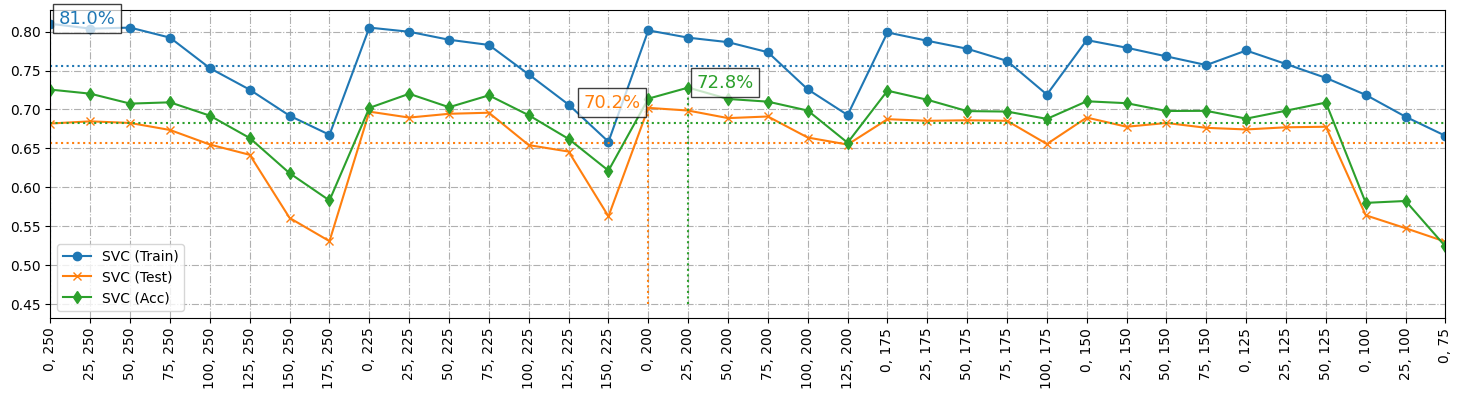

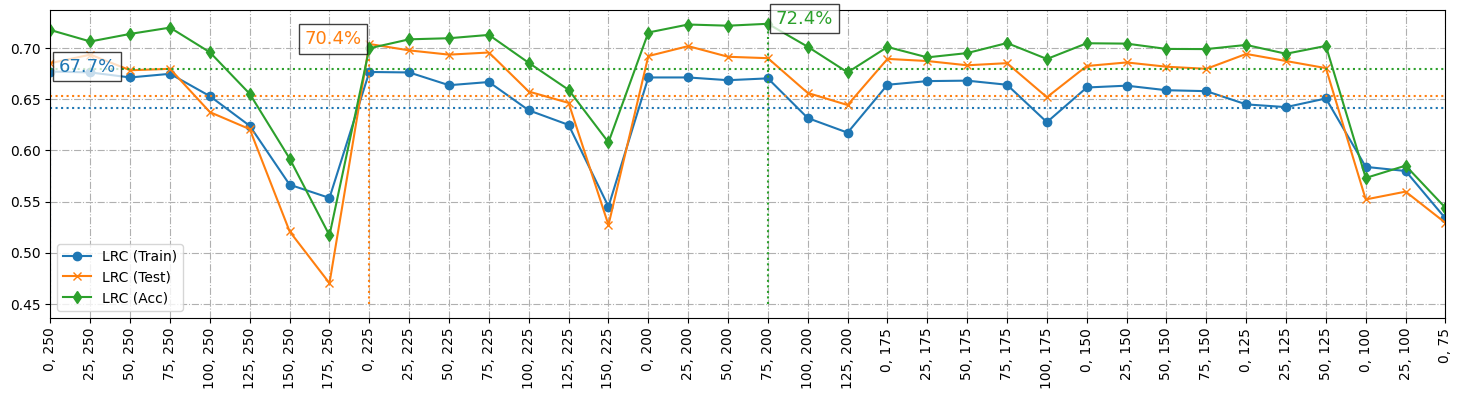

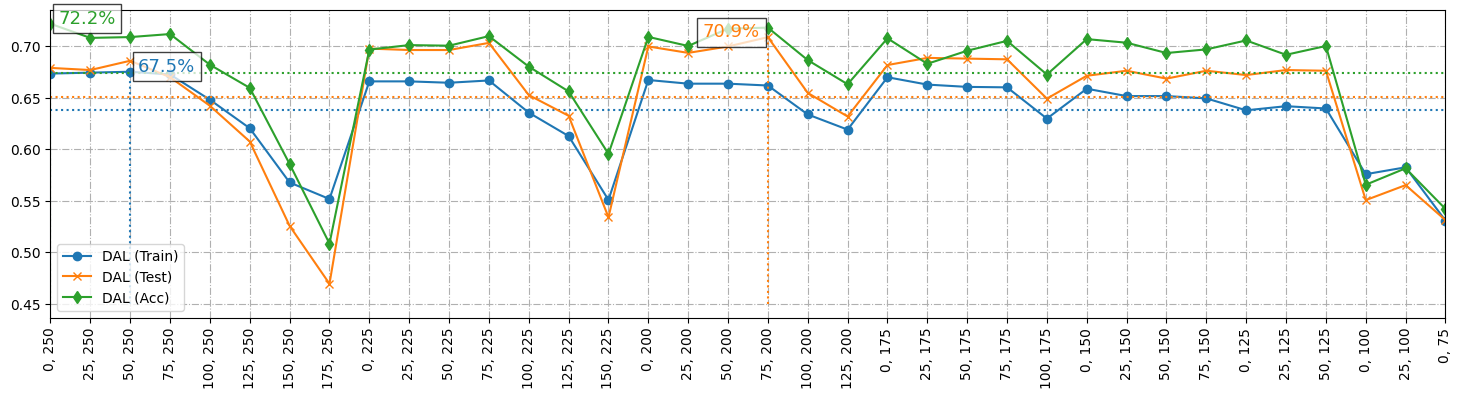

In [41]:
nb  = len(vclf)
res = [table[i :: nb] for i in range(nb)]
pos = [f"{x[0]}, {x[1]}" for x in res[0]]
xtk = range(len(pos))
fnt = {
        'fontsize': 13,
        'fontweight': 'medium',
        'bbox': dict(facecolor='white', alpha=.75),
    }

for i in range(nb):
    plt.figure(figsize=(18, 4))
    plt.xlim([xtk[0], xtk[-1]])
    plt.grid(visible=True, ls='-.')
    plt.xticks(xtk, labels=pos, rotation='vertical')

    for j in range(1, 4):
        crv =np.array([float(x[1 + j]) for x in res[i]])
        max_=max(crv)
        x_  =np.where(crv == max_)[0][0]
        k   =j % 2
        off =.2 * ([-1, 1][k])
        line=plt.plot(xtk, crv, f'{'_oxd'[j]}-', label=f'{leg[i]} ({['', 'Train', 'Test', 'Acc'][j]})')
        c   =line[-1].get_color()

        fnt['horizontalalignment'] = ['right', 'left'][k]

        plt.hlines(np.mean(crv), 0, 250, ls=':', colors=c)
        plt.vlines(x_, .45, max_, ls=':', colors=c)
        plt.text(x_ + off , max_, f'{max_:.1%}', c=c, fontdict=fnt)
    
    plt.legend()
    plt.show();

In [ ]:
from sklearn.manifold import TSNE

tnse=TSNE(n_components=2, learning_rate='auto')

X_embedded=tnse.fit_transform(X_train_scaled)

print(tnse.kl_divergence_, tnse.learning_rate_)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train)
plt.show()

# pd.crosstab(X_embedded[:, 0].T, y_train), random_state=42

https://raphaelvallat.com/bandpower.html

#### • Test EEG Torch

In [ ]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as foo

from torchvision import datasets            # type: ignore
from torchvision.transforms import ToTensor # type: ignore

torch.cuda.is_available()

In [ ]:
32 << 4

In [ ]:
# https://www.kaggle.com/code/banggiangle/cnn-eeg-pytorch

EPOCH   : int   = 10
BATCH   : int   = 32       # Taille des lots
DROPOUT : float = 1 / 4

OPTIMIZER = Adam     # adamax, , adafactor, adam, nadam
# kl_divergence mean_squared_logarithmic_error mean_absolute_error
LOSS      = 'sparse_categorical_crossentropy'
K_SIZE    = (5)

CONV  = nn.Conv2d
POOL  = nn.MaxPool2d
ACTIV = nn.ReLU()   # PReLU, LeakyReLU

class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=BATCH, num_classes=2, drop_=DROPOUT):
        super(CNN, self).__init__()

        in_ = out_channels

        self.pool  = POOL(2, 2)
        self.convs = [CONV(in_channels, in_, 3, padding=1)]

        for i in range(3):
            self.convs.append(CONV(in_ << i, in_ << (i + 1), 3, padding=1))
        
        self.dropout = nn.Dropout(drop_)
        self.fc1     = nn.Linear(in_ << 5, in_ << 2)
        self.fc2     = nn.Linear(in_ << 2, num_classes)
        
        # CNN.to(device)

        # self.conv1   = nn.Conv2d(in_channels, out_, 3, padding=1)
        # self.conv2   = nn.Conv2d(out_, out_ << 1, 3, padding=1)
        # self.conv3   = nn.Conv2d(out_ << 1, out_ << 2, 3, padding=1)
        # self.conv4   = nn.Conv2d(out_ << 2, out_ << 3, 3, padding=1)
        # self.conv1   = nn.Conv2d(in_channels, 32, 3, padding=1)
        # self.conv2   = nn.Conv2d(32, 64, 3, padding=1)
        # self.pool    = nn.MaxPool2d(2, 2)
        # self.conv3   = nn.Conv2d(64, 128, 3, padding=1)
        # self.conv4   = nn.Conv2d(128, 256, 3, padding=1)

        # self.dropout = nn.Dropout(.25)
        # self.fc1     = nn.Linear(1024, 128)
        # self.fc2     = nn.Linear(128, num_classes)

    def forward(self, x):
        for c in self.convs: x = self.pool(foo.relu(c(x)))

        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = torch.flatten(x, 1)  # Aplatit toutes les dimensions sauf la dimension des batch
        x = foo.relu(self.fc1(x))
        x = self.fc2(x)

        # x = self.pool(foo.relu(self.conv1(x)))
        # x = self.pool(foo.relu(self.conv2(x)))
        # x = self.pool(foo.relu(self.conv3(x)))
        # x = self.pool(foo.relu(self.conv4(x)))

        return x

In [ ]:
# class EEG_RNN(nn.Module):
#     def __init__(self, input_size: int, hidden_size: int, output_size: int):
#         super(EEG_RNN, self).__init__()
        
#         self.hidden_size=hidden_size
#         self.rnn=nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc =nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         h0     =torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
#         out, _ =self.rnn(x, h0)
#         out    =self.fc(out)
        
#         return out

# print(titre("Custome 'train_test_split'", 50))
# print('Torseur train\t:', *[np.shape(x) for x in train_parts.parts])
# print('Torseur test\t:', *[np.shape(x) for x in test_parts.parts])
# print('-' * 50)

# X, y=next(iter(train_loader))
# X, y=next(iter(DataLoader(train_parts, batch_size=BATCH, shuffle=True)))

# train_loader

# model.append(CONV(in_channels=3, out_channels=3, kernel_size=5, padding=2))
# model.append(CONV(in_channels=BATCH, out_channels=BATCH, kernel_size=BATCH >> 1, stride=7))
# model.append(POOL(kernel_size=2))
# model.append(ACTIV)

# in_, out_=BATCH, BATCH << 1

# model.append(CONV(in_channels=in_, out_channels=out_, kernel_size=3))
# model.append(ACTIV)
# model.append(POOL(kernel_size=2))

# in_, out_=in_ << 1, out_ << 1

# model.append(CONV(in_channels=in_, out_channels=out_, kernel_size=3))
# model.append(ACTIV)
# model.append(POOL(kernel_size=2))

# model.append(nn.Flatten())
#    #    nn.Linear(64 * 6 * 6, 64),
# model.append(nn.Linear(out_, 4))
    
   # conv(in_channels=512 >> 1, out_channels=512 >> 2, kernel_size=3),
   # nn.ReLU(),
   # pool(kernel_size=2),
    
   # conv(in_channels=512 >> 2, out_channels=512 >> 3, kernel_size=3),
   # nn.ReLU(),
   # pool(kernel_size=2),

# print(model.summary())

# criterion =nn.RNN((3, 512), hidden_dim, layer_dim, batch_first=True, nonlinearity='relu') # nn.CrossEntropyLoss()
# preprocess=weights.transforms()
# y_pred    =model(X.to(device))

# criterion(y_pred, y.to(device))

In [ ]:
from tqdm.notebook import tqdm

device = "cpu"

train_parts  = Graphein(train_X, train_y, gd.eeg_Chans, numbers, CHUNK, LAG)
test_parts   = Graphein(test_X, test_y, gd.eeg_Chans, numbers, CHUNK, LAG)

train_loader = DataLoader(train_parts, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_parts, batch_size=BATCH, shuffle=True)

model = CNN(BATCH)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss() # Définir la fonction de perte
optimizer = OPTIMIZER(model.parameters(), lr=1e-3)

# model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # output 62x62x16
#    nn.MaxPool2d(kernel_size=2), # output 31x31x16
#    nn.ReLU(),
    
#    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # output 29x29x32
#    nn.ReLU(),
#    nn.MaxPool2d(kernel_size=2), # output 14x14x32
    
#    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # output 12x12x64
#    nn.ReLU(),
#    nn.MaxPool2d(kernel_size=2), # output 6x6x64
    
#    nn.Flatten(),
#    nn.Linear(64 * 6 * 6, 64),
#    nn.ReLU(),
#    nn.Linear(64, 4)
# )

model.to(device)

# X_batch, y_batch = next(iter(train_loader))
# y_pred = model(X_batch.to(torch.float))

# criterion(y_pred, y_batch.to(device))

# model.compile() #optimizer=OPTIMIZER, loss=LOSS, metrics=['acc']

for epoch in range(EPOCH):
    model.train()

    # outputs=model(X.unsqueeze(2))  # Add a dimension for input size
    # loss   =criterion(outputs, y.unsqueeze(2))
    
    loss_total   = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch:1d}", leave=True, disable=False)
 
    for i, batch in enumerate(progress_bar):
        # Batch de données
        X_batch, y_batch = batch
        # Device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        model.zero_grad()   # Gradient mis 0

        # Calcul de prédiction
        y_pred = model(X_batch.to(torch.float32)) 

        # print(y_pred.shape)
        # print(y_batch.shape)
        # print(y_batch)

        # Calcul de la fonction de perte
        loss = criterion(y_pred, y_batch) 
        
        # Backpropagation: calculer le gradient de la loss en fonction de chaque couche
        loss.backward()
        
        # Clipper le gradient entre 0 et 1 pour plus de stabilité
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Descente de gradient: actualisation des paramètres
        optimizer.step()
        
        loss_total += loss.item()
        
        progress_bar.set_postfix({"training_loss": "{:.3f}".format(loss_total / (i + 1))})
    
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

#### • Test prédiction

In [ ]:
### • Visualisation des spectrogrammes / Test

def logMelSpectrogram(data: Vector, rate: int, dt: float=1e-2) -> Vector:
    tps=1 << int(np.floor(np.log2(rate * dt)))
    # print(tps)
    # Spectrogramme
    stfts=np.abs(librosa.stft(y=data, n_fft=tps, hop_length=1 << 2, center=True)).T
    # Filtre de MEL
    liny =librosa.filters.mel(sr=rate, n_fft=tps + 1, n_mels=stfts.shape[-1]).T
    # Application du filtre au spectrogramme
    mel_ =np.tensordot(stfts, liny, 1)

    return np.log(mel_ + 1e-6)
    
def img_spectrogram(raw: Vector, rate: int, nfft: int=1 << 10) -> Vector:
    return librosa.feature.melspectrogram(y=raw, sr=rate, hop_length=1, 
                            n_fft=nfft, n_mels=32, fmin=0, fmax=20, win_length=32)

def spectrogram_dep(data: Board, rate: int, channels: Clause, n_row: int=5, n_col: int=12):
    sample=np.random.default_rng().integers(data.shape[0], size=n_row)

    sample.sort()

    plt.figure(figsize=(18, 2 * .48 * n_row))

    pos=0

    for k in sample:
        for c in channels:
            # x  =normalized(data[c][k])
            raw=img_spectrogram(raw=data[c][k], rate=rate)
            pos += 1
            
            plt.subplot(n_row, n_col, pos)
            plt.title(f"{((pos - 1) // 3) + 1} . {k} - {c}", fontsize=8)
            librosa.display.specshow(data=1 - raw, sr=rate, hop_length=1)
            
            # pos=n_col * (i >> 1) + j
            # f, t, Sxx=signal.spectrogram(x, rate)
            # plt.subplot(n_row, n_col, pos + 4)
            # plt.pcolormesh(t, f, 1 - Sxx, shading='gouraud')

    plt.tight_layout()
    plt.show();

def spectrogram(data: Board, rate: int, channels: Clause, n_row: int=5, n_col: int=12):
    sample=np.random.default_rng().integers(data.shape[0], size=n_row)

    sample.sort()

    plt.figure(figsize=(18, 2 * .48 * n_row))

    freq=np.arange(1, rate >> 1)
    pos =0
    # extd=np.append([0, 1, 1], freq[-1])
    
    for k in sample:
        for c in channels:
            pos += 1
            x  =normalized(data[c][k])
            coefficients, _=pywt.cwt(x, scales=freq, wavelet='cmor')

            plt.subplot(n_row, n_col, pos)
            plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet') #, extent=extd
            # plt.colorbar(label="Magnitude")
            # plt.ylabel("Scale")
            # plt.xlabel("Time")
            # plt.title("CWT of a Chirp Signal")
            plt.axis('off')

    plt.show()

def plot_logMelSpectrogram(data, rate):
    sns.heatmap(np.rot90(logMelSpectrogram(data, rate)), cmap='inferno')
    
    # loc, _=plt.xticks()
    # l     =np.round((loc - loc.min()) * len(data) / fe / loc.max(), 2), vmin=-6

    # plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")

In [ ]:
H=[list(harmonic(x, bands_coeff).values()) for x in [df_train[c] for c in eeg_Chans]]

np.shape(H), np.shape(np.stack(np.stack(H, axis=1), axis=2)), np.shape(H[0][1][0])
# harmonic(trains['C3'][256], bands_coeff).values())), H

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df_train.drop(columns=['EventType']),
                                                    df_train['EventType'], test_size=.2, random_state=42)

# X_train, X_test, y_train, y_test=train_test_split([v.tolist() for v in np.array(trains[eeg_Channels])],
#                                                     trains['EventType'], test_size=.2, random_state=42)

In [ ]:
# train_dataset=np.array(X_train)
# test_dataset =X_test

# train_dataset=structure(X_train, SAMPLE_RATE, eeg_Chans[:2])
# test_dataset =structure(X_test, SAMPLE_RATE, eeg_Chans[:2])

# train_dataset=structure(X_train, SAMPLE_RATE, eeg_Chans[: 2])
# test_dataset =structure(X_test, SAMPLE_RATE, eeg_Chans[: 2])

train_dataset=structure(df_train.drop(columns=['EventType']), SAMPLE_RATE, eeg_Chans[: 2])
test_dataset =structure(df_test.drop(columns=['EventType']), SAMPLE_RATE, eeg_Chans[: 2])

# print(train_dataset.shape)

In [ ]:
#### • Test prédiction

# UNITS    : int  =100
BATCHSIZE: int  =32
EPOCH    : int  =1000
ZERO     : int  =32
DROPOUT  : float=1 / 4
K_SIZE   =(5)

OPTIMIZER='AdamW'     # adamax, , adafactor, adam, nadam
# kl_divergence mean_squared_logarithmic_error mean_absolute_error
LOSS     ='sparse_categorical_crossentropy'
ACTIV    =ReLU   # PReLU, LeakyReLU

model=Sequential([
    # - Couche 1 -
    Conv1D(filters=ZERO, kernel_size=K_SIZE, dilation_rate=2,
           input_shape=train_dataset.shape),
    ACTIV(),
    MaxPooling1D(pool_size=2, strides=1),
    Dropout(rate=DROPOUT),
    
    # - Couche 2 -
    Conv1D(filters=ZERO << 1, kernel_size=K_SIZE, dilation_rate=2),
    ACTIV(),
    MaxPooling1D(pool_size=2, strides=1),
    Dropout(rate=DROPOUT),

    # - Couche 3 -
    Conv1D(filters=ZERO << 2, kernel_size=K_SIZE, dilation_rate=2),
    ACTIV(),
    MaxPooling1D(pool_size=2, strides=1),
    Dropout(rate=DROPOUT),

    # - Flatten layer -
    Flatten(),
    GlobalAveragePooling1D(),
    
    # - Couches de sortie -
    Dense(units=ZERO << 2),
    ACTIV(),
    Dropout(rate=DROPOUT),
    Dense(units=len(hands_event), activation='softmax'), # sigmoid 
])

model.summary()
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['acc'])

print()

stop   =EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history=model.fit(train_dataset, y_train, validation_data=(test_dataset, y_test), verbose=1,
                    batch_size=BATCHSIZE, epochs=EPOCH, callbacks=[stop])

In [ ]:
pred=model.predict(test_dataset)

sum([np.where(x > .5)[0][0] for x in pred] == y_test) / len(pred)

In [ ]:
history_dict=history.history
loss_values =history_dict['loss']
acc_values  =history_dict['accuracy']
absc        =range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(absc, loss_values, label='Loss')
plt.plot(absc, acc_values, label='Accuracy')
plt.title('Training')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(absc, history_dict['val_loss'], label='Loss')
plt.plot(absc, history_dict['val_accuracy'], label='Accuracy')
plt.title('Testing')
plt.xlabel('Epochs')
plt.legend()
plt.show();

#### • Visualisation densité spectrale du Signal

In [ ]:
### • Visualisation Densité Spectral du Signal

plot_psd(entrants, train_runs, rate=SAMPLE_RATE, Channels=eeg_Chans, titled=headers)

#### • Densité spectrale / échantillon

In [ ]:
### • Densité spectral / échantillon

inc  =40
scp=samples(train_samples, inc)
boolInt=-2

plt.figure(figsize=(15, inc * 1.5))

for i in scp:
    boolInt += 2

    for c in eeg_Chans:
        target=train_runs[0][c][i]
        yest, Pxx_den=signal.welch(target, SAMPLE_RATE)   # , scaling='spectrum'
        
        plt.subplot(inc, 4, boolInt + 1)
        plt.semilogy(yest, Pxx_den, label=c)
        plt.title(f"welch - {i + 1}", fontsize=11)
        plt.grid()

        plt.subplot(inc, 4, boolInt + 2)
        res, _=plt.psd(target, Fs=SAMPLE_RATE, label=c) # , NFFT=NFFT
        plt.title(f"psd - {i + 1}", fontsize=11)
        plt.xlabel('')
        plt.ylabel('')
        # plt.legend()

plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.show();

# f, Pxx_den=signal.welch(train_eras[0]['C3'][752], SAMPLE_RATE)

# print(len(Pxx_den))

#### • Visualisation Epoques

In [ ]:
### • Visualisation Epoques

for i in range(len(files))[:: 3]:
    plot_signal(entrants[i], parts[i], train_spots[0][i], train_spots[1][i], channels=eeg_Chans, # 
                period=CHUNK, lag=LAG, title=headers[i])

#### • Visualisation décomposition des signaux

In [ ]:
### • Visualisation Décomposition des signaux

# Test de décomposition des signaux en bandes de fréquences spécifiques compatibles avec les répartitions usuelles
# dans le domaine des EEG ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for input, token in zip(train_runs, ['Gauche', 'Droite']):
    print(f"Exemples - Évènement Discriminé Main {token}")
    plot_wavelets(input, bands_coeff, eeg_Chans, scope=30, headers=headers)

#### • Visualisation des spectrogrammes (test)

In [ ]:
for i, t in zip(numbers, ['Gauche', 'Droite']):
    print(f"Exemples - Évènement Discriminé Main {t}")
    spectrogram(train_runs[i], SAMPLE_RATE, eeg_Chans, 32)

#### • MNE époque (test)

In [ ]:
### • MNE époque (test)

raw_csv=entrants[0][eeg_Chans]
info   =mne.create_info(ch_names=eeg_Chans, sfreq=SAMPLE_RATE, ch_types='eeg')
raw_mne=mne.io.RawArray(raw_csv.T * 1e-6, info)
sites    =np.where(entrants[0]['EventStart'] == 1)[0]

# display(compare(np.sort(np.concatenate((train_spots[0][0], train_spots[1][0]))), loc))

tmin, tmax=-0., 1

# loc=mne.find_events(raw_mne, stim_channel='C3')
# event_id=dict(C3=1, aud_r=2, vis_l=3, vis_r=4)
# raw=mne.io.Raw(raw_mne, preload=True)
# raw.filter(2, None, method='iir')           # replace baselining with high-pass
# events=mne.read_events(event_fname)

# raw.info['bads']=['MEG 2443']  # set bad channels
# picks=mne.pick_types(info, meg='grad', eeg=True, eog=False, exclude='bads')
# Read epochs
absc=mne.Epochs(raw_mne, np.array([sites, sites, sites]).T, None, tmin, tmax, proj=False,
                    picks=None, baseline=None, preload=True, verbose=False) # event_id picks

# labels=epochs.events[::5, -1]

# events

# raw_mne.plot();

# raw_mne['C3'][0][0], len(df_train_csv[2]['Cz'])

display(absc)

#### • Test de classification - Proposition 02

In [ ]:
b, target=bands_coeff['Theta']

i=np.random.randint(np.shape(X)[0])
target=df_train['C4'][i] - df_train['C3'][i]
# X=[np.sign(s) for s in (trains['C4'] - trains['C3'])]
# y={band: bandpass_filter(X[i], b, a) for band, (b, a) in bands_coeff.items()}

plt.figure()
# plt.style.use('')

plt.plot(normalized(bandpass_filter(target, b, target)), label='C4 - C3')
plt.plot(normalized(bandpass_filter(np.sign(target), b, target)), label='[C4 - C3]', c=np.random.rand(1, 3)[0])
# plt.plot(pywt.dwt(y, wavelet='db4')[0], label='C4 - C3')
# plt.plot(pywt.dwt(np.sign(y), wavelet='db4')[0], label='[C4 - C3]')
# plt.plot(np.zeros(512), ls='--', c=np.random.rand(1, 3)[0])

# print(np.shape(pywt.dwt(y, wavelet='db8')))

# plt.plot(bandpass_filter(np.sign(trains['C3'][i]), b, a), label='C3')
# plt.plot(bandpass_filter(np.sign(trains['C4'][i]), b, a), label='C4')
# plt.plot(bandpass_filter(np.sign(trains['Cz'][i]), b, a), label='Cz')

# for (band, signal) in reversed(y.items()):
#     plt.plot(pd.Series(signal), label=f'{band}', c=np.random.rand(1, 3)[0])

plt.title(f"{i}")
plt.legend(loc='upper right')

plt.grid()
plt.tight_layout()
plt.show();

In [ ]:
params={
    ## K-plus proches voisins
    'knn__n_neighbors': range(2),
    ## SVM
    'svm__C'     : [0.1, 1, 5],
    'svm__kernel': ['linear', 'softmax', 'sigmoid', 'rbf'],
    ## RandomForest
    # 'rf__max_features'     : ['sqrt', 'log2', None],
    # 'rf__min_samples_split': range(2, 32, 2),
    # , ('rf', clf3), ('rf', clf3)
    'estimators': [[('knn', knc), ('svm', svm)], [('knn', knc), ('svm', svm)]] 
    }

grid=model_selection.GridSearchCV(estimator=Voting_clf, param_grid=params, cv=5) \
    .fit(X_train_scaled, y_train)

# parametres={'max_features': ['log2', 'sqrt', None], 'min_samples_split': range(2, 32, 2)}

# vclf=model_selection.GridSearchCV(estimator=clf3, param_grid=parametres, cv=3) \
#     .fit(X_train_scaled, y_train)

print(grid.best_estimator_)
print(grid.best_score_)
print('score train:', grid.score(X_train_scaled, y_train))
print('score test:', grid.score(X_test_scaled, y_test))

# print(vclf.best_estimator_, vclf.best_params_, vclf.best_score_)
# print('score train:', grid.score(X_train_scaled, y_train), vclf.score(X_train_scaled, y_train))
# print('score test :', grid.score(X_test_scaled, y_test), vclf.score(X_test_scaled, y_test))

df_train_cpy, event_start=fancy_df(entrants, targets['EventType'], hands_event, CHUNK)

fig, axes=plt.subplots(1, 1, figsize=(24, 5), sharey=True)
sig=.05

axes.plot(entrants['C3'])

for p in event_start:
    axes.axvspan(p[0] - (CHUNK >> 1), p[0] + 1.5 * CHUNK, facecolor='orangered', alpha=.5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Score')

In [ ]:
boolInt=16
start  =event_start[boolInt][0]
entrant=start + CHUNK
input  =df_train_cpy['C3_4'][start: entrant]
smooth =input.copy()
inc    =5
alpha  =1 / 3
dec    =int(inc / alpha)

plt.figure(figsize=(24, 5))
plot_window(entrants, ['C3', 'C4', 'C3 + C4'], start, CHUNK)

# Lissage des hautes fréquences
for _ in range(inc):
    smooth=simple_exponential_smoothing(smooth, alpha, 0)

smooth=pd.Series(index=range(start, entrant + inc - dec), data=smooth[dec:])

# plt.plot(raw - smooth, label=hands[event_start[pos][1]])
plt.plot(smooth, '--', label=hands_event[event_start[boolInt][1]])
plt.legend()
plt.show()

#### • Apendix

<h2 style="text-align:center" ><b>EEG</b> - Prédiction des Mouvements Imaginaires de la Main</h2>

---

#### **1. Le projet**
- Intoduction  
https://github.com/DataScientest-Studio/mar24_cds_eeg/blob/eric/references/Description_projet_EEG.pdf  
https://www.bbci.de/competition/iv/desc_2b.pdf
- Ressources / Données   
https://www.kaggle.com/competitions/ucsd-neural-data-challenge/overview  
- Bibliographie  
https://www.bbci.de/competition/iv/desc_2b.pdf
#### **2. Liens utils**
- SciPy - *open-source software for mathematics, science, and engineering*  
https://docs.scipy.org/doc/scipy/index.html  
https://docs.scipy.org/doc/scipy/reference/signal.html  
- MNE - *MEG + EEG Analysis & Visualisation*
   - Accueil  
   https://mne.tools/stable/index.html

   - MNE - Data structures from arbitrary data  
   https://mne.tools/stable/auto_tutorials/io/10_reading_meg_data.html#creating-mne-data-structures-from-arbitrary-data-from-memory
   
   - MNE - EEG Preprocessing  
   https://mne.tools/dev/auto_tutorials/preprocessing/index.html  

- pyRiemann - *Biosignals classification with Riemannian geometry*  
https://pyriemann.readthedocs.io/en/latest/  
- neurodsp - *Neuro Digital Signal Processing Toolbox*  
https://neurodsp-tools.github.io/neurodsp/index.html#
- Rythme Mu  
https://fr.wikipedia.org/wiki/Rythme_Mu
- Spectrogram from EEG  
https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg
- Divers  
https://signalprocessingsociety.org/  
https://fr.wikipedia.org/wiki/Filtre_de_Butterworth  
https://fr.wikipedia.org/wiki/Moyenne_mobile  
https://terpconnect.umd.edu/~toh/spectrum/Differentiation.html  
https://perso.etis-lab.fr/ghaffari/2014_CCMB_Floride_USA.pdf  
https://www.youtube.com/watch?v=wB417SAbdak&list=PLXc9qfVbMMN2TAoLHVW5NvNmJtwiHurzw  
https://fastercapital.com/fr/sujet/identification-des-artefacts-de-traitement-du-signal-dans-des-sc%C3%A9narios-r%C3%A9els.html#:~:text=L'inspection%20visuelle%20est%20la,des%20pertes%20et%20du%20bruit.  
   - Z-Score Normalisation  
   https://fr.wikipedia.org/wiki/Cote_Z_(statistiques)  
   https://typeset.io/questions/why-is-z-score-normalisation-necessary-in-pre-processing-eeg-1xv5jepyq5  

   - Traitement numérique du signal  
   https://fr.wikipedia.org/wiki/Traitement_num%C3%A9rique_du_signal  
   - Ondelette  
      - Wiki  
      https://fr.wikipedia.org/wiki/Ondelette  

      - L’analyse par ondelettes dans la vie de tous les jours  
      https://interstices.info/lanalyse-par-ondelettes-dans-la-vie-de-tous-les-jours/  

      - A guide for using the Wavelet Transform in Machine Learning  
      https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
      
      - pyWavelets - *open source wavelet transform*  
      https://pywavelets.readthedocs.io/en/latest/

      - Ondelettes et applications  
      https://www.i2m.univ-amu.fr/~caroline.chaux/GEOMDATA/TI-te5215.pdf

   - Maximum de vraisemblance  
   https://pmarchand1.github.io/ECL8202/notes_cours/03-Maximum_vraisemblance.html  
   https://fr.wikipedia.org/wiki/Maximum_de_vraisemblance#:~:text=En%20statistique%2C%20l'estimateur%20du,maximisant%20la%20fonction%20de%20vraisemblance  

   - Transformation de Fourier discrète  
   https://fr.wikipedia.org/wiki/Transformation_de_Fourier_discr%C3%A8te  
      - La Transformation de Fourier n’est pas adaptée à l’analyse des signaux non stationnaires.
   - Neural Data Science in Python  
   https://neuraldatascience.io/intro.html

   - Preprocessing of EEG  
   https://www.frontiersin.org/articles/10.3389/fninf.2015.00016/full#:~:text=The%20depositable%20preprocessing%20pipeline%20consists,with%20a%20low%20recording%20SNR  
   https://typeset.io/papers/preprocessing-of-eeg-4go8vhcbty  
   https://learn.neurotechedu.com/preprocessing  
   https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html  
   
   - Biblio:  
   https://perso.telecom-paristech.fr/bloch/P6Image/ondelettestrsp.pdf  
   https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/ondelettesIMAT.pdf  
   http://w3.cran.univ-lorraine.fr/perso/radu.ranta/pdf/cours_deb_ond%28fr%29.pdf
   
   - Digital Filtering  
   http://notebooks.pluxbiosignals.com/notebooks/Categories/Pre-Process/digital_filtering_eeg_rev.html

   - Processus stationnaire  
   https://fr.wikipedia.org/wiki/Processus_stationnaire

   - Analyse en composantes principales  
   https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales#:~:text=L'ACP%2C%20d%C3%A9sign%C3%A9e%20en%20g%C3%A9n%C3%A9ral,une%20grandeur%20physique%2C%20comme%20les